# Описание проекта

Наш проект будет основываться на данных по прогнозированию объёмов продаж тысяч товаров, реализованных в различных магазинах Favorita, расположенных в Эквадоре.

# Характеристики и параметры временных рядов

Познакомимся с одним из способов выделения трендовой и сезонной компонент ряда и визуального анализа шума.

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.3 MB/s eta 0:00:00


In [39]:
import pandas as pd
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
import warnings
import holidays

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels import api
from matplotlib import pyplot
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from xgboost import XGBRegressor, plot_importance
from catboost import CatBoostRegressor

%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
col = ['date', 'store_nbr', 'unit_sales']
gen = pd.read_csv(  # считываем датасет
    '/content/drive/MyDrive/train.csv.zip',
    usecols = col,
    chunksize = 10000000
)
df = pd.concat((x.query('store_nbr == 25') for x in gen), ignore_index = True)
print(f'Исходный датасет содержит {len(df)} элементов.')

# группируем данные по дате и суммируем количество всех продаж
df = df.groupby('date')['unit_sales'].sum().reset_index()
df.head()

Исходный датасет содержит 2057020 элементов.


,date,unit_sales
0,2013-01-01,2511.619
1,2013-01-02,5316.224
2,2013-01-03,4442.913
3,2013-01-04,4844.354
4,2013-01-05,5817.526


Заменяем название столбца 'unit_sales' на 'sales'.

In [ ]:
df.columns = (['date', 'sales'])
df.head()  # смотрим на первые несколько строчек

,date,sales
0,2013-01-01,2511.619
1,2013-01-02,5316.224
2,2013-01-03,4442.913
3,2013-01-04,4844.354
4,2013-01-05,5817.526


Переводим индексы к стандарту pd.Datetime, чтобы потом это можно было скормить seasonal_decompose.

In [ ]:
df = df.set_index(pd.DatetimeIndex(df['date']))
df.head()  # смотрим на результат

,date,sales
date,,
2013-01-01,2013-01-01,2511.619
2013-01-02,2013-01-02,5316.224
2013-01-03,2013-01-03,4442.913
2013-01-04,2013-01-04,4844.354
2013-01-05,2013-01-05,5817.526


Замечаем, что т. к. у нас теперь есть индекс date, нам больше не нужен столбец date, который его дублирует.

In [ ]:
df.drop(['date'], axis = 1, inplace = True)

Снова проверяем, что всё в порядке. Вообще проверять данные на каждом шаге кода - хорошая привычка.

In [ ]:
df.head()

,sales
date,
2013-01-01,2511.619
2013-01-02,5316.224
2013-01-03,4442.913
2013-01-04,4844.354
2013-01-05,5817.526


Применим seasonal_decompose. Эта функция разложит ряд на трендовую, сезонную и шумовую составляющие.

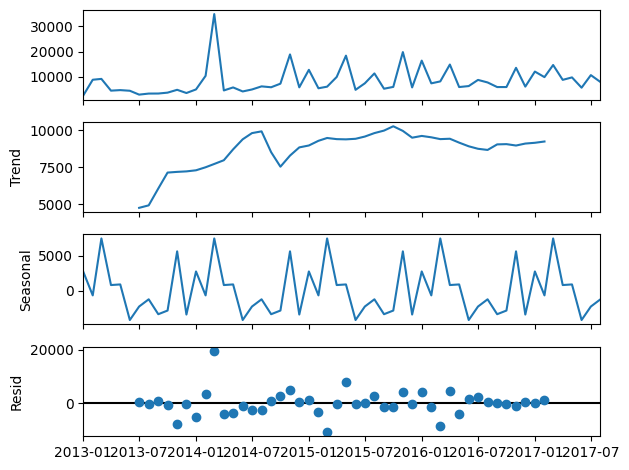

In [ ]:
decomposition = seasonal_decompose(
    df.asfreq('MS').fillna(df['sales'].median()),  # заполняем пропуски медианой
    model = 'additive'
)
decomposition.plot()
pyplot.show()  # любуемся результатом

Анализ результата:
- в ряде присутствует незначительный тренд на рост и ярко выражена годовая сезонность,
- остатки ряда похожи на хаотичный белый шум и скорее всего не содержат закономерности.

In [ ]:
trend_part = decomposition.trend        # отдельно трендовая составляющая
seasonal_part = decomposition.seasonal  # отдельно сезонная составляющая
residual_part = decomposition.resid     # отдельно шум: то, что осталось

In [ ]:
residual_part.head()  # посмотрим повнимательнее на остатки в начале ряда

date
2013-01-01   NaN
2013-02-01   NaN
2013-03-01   NaN
2013-04-01   NaN
2013-05-01   NaN
Freq: MS, Name: resid, dtype: float64

In [ ]:
residual_part.tail()  # посмотрим повнимательнее на остатки в конце ряда

date
2017-04-01   NaN
2017-05-01   NaN
2017-06-01   NaN
2017-07-01   NaN
2017-08-01   NaN
Freq: MS, Name: resid, dtype: float64

В конце и в начале стоят значения NaN. Это связано с особенностями алгоритма seasonal_decompose. Если мы хотим далее анализировать остатки, необходимо избавиться от этих некорректных значений.

In [ ]:
print(f'Шумовая часть содержит {len(residual_part)} элементов.')

Шумовая часть содержит 56 элементов.


In [ ]:
residual_part = residual_part.dropna()
residual_part.head()

date
2013-07-01     388.546264
2013-08-01    -397.480440
2013-09-01     613.763737
2013-10-01    -634.789044
2013-11-01   -8011.180450
Freq: MS, Name: resid, dtype: float64

In [ ]:
print(f'Шумовая часть содержит {len(residual_part)} числовых элементов.')
print(f'Сезонная часть содержит {len(seasonal_part)} элементов.')
print(f'''Трендовая часть содержит {
    len(trend_part) - trend_part.isnull().sum()
} числовых элементов.''')

Шумовая часть содержит 44 числовых элементов.
Сезонная часть содержит 56 элементов.
Трендовая часть содержит 44 числовых элементов.


In [ ]:
test = adfuller(df['sales'])  # выполняем тест Дики-Фуллера
print('adf:', test[0])
print('p-value:', test[1])
print('critical values:', test[4])

# проверка, больше ли критического полученное значение для нашего ряда
if test[0] > test[4]['5%']:
    print('ряд не стационарен')
else:
    print('ряд стационарен')

adf: -4.858992665318184
p-value: 4.188394192907693e-05
critical values: {'1%': -3.4344642432857992, '5%': -2.8633571955690647, '10%': -2.5677374399794197}
ряд стационарен


# Особенности валидации временных рядов

In [ ]:
# разбиваем временной ряд на три набора
tscv = TimeSeriesSplit(n_splits = 3, test_size = 7)
train_test_groups = tscv.split(df.sales)

# выводим размеры полученных подвыборок
for train_index, test_index in train_test_groups:
    print('TRAIN size:', len(train_index), 'TEST size:', len(test_index))

TRAIN size: 1597 TEST size: 7
TRAIN size: 1604 TEST size: 7
TRAIN size: 1611 TEST size: 7


# Расчёт факторов при помощи pandas

### Скользящее среднее

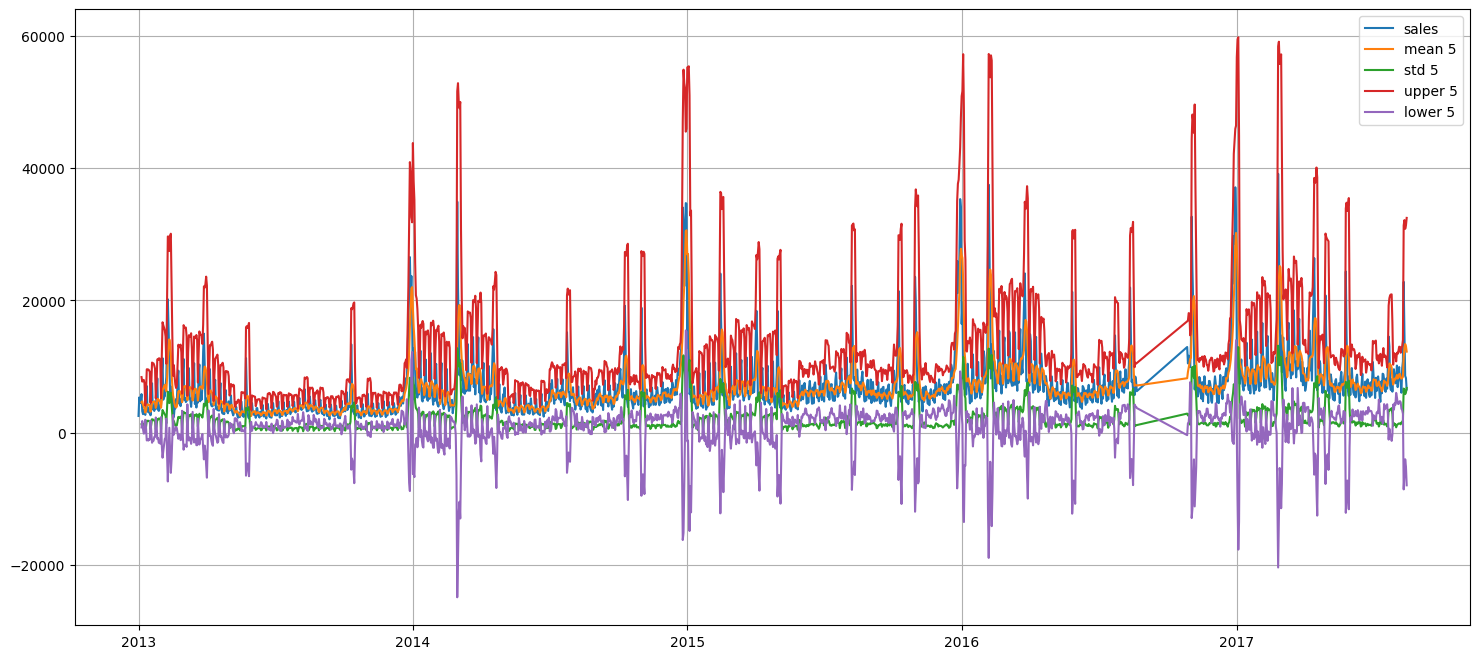

In [ ]:
# строим скользящее среднее с окном 5
df['rolling_mean_5'] = df.sales.rolling(window = 5).mean()

# строим скользящее квадратичное отклонение с окном 5
df['rolling_std_5'] = df.sales.rolling(window = 5).std()

# строим линии Боллинджера
df['upper_5'] = df['rolling_mean_5'] + 3 * df['rolling_std_5']
df['lower_5'] = df['rolling_mean_5'] - 3 * df['rolling_std_5']

# отображаем оконные факторы на графике
f, ax = pyplot.subplots(1, 1, figsize = (18, 8))
ax.plot(df.index, df.sales)           # исходные данные
ax.plot(df.index, df.rolling_mean_5)  # скользящее среднее
ax.plot(df.index, df.rolling_std_5)   # стандартное квадратичное отклонение
ax.plot(df.index, df.upper_5)         # верхняя линия Боллинджера
ax.plot(df.index, df.lower_5)         # нижняя линия Боллинджера
ax.legend(['sales', 'mean 5', 'std 5', 'upper 5', 'lower 5'])
ax.grid()

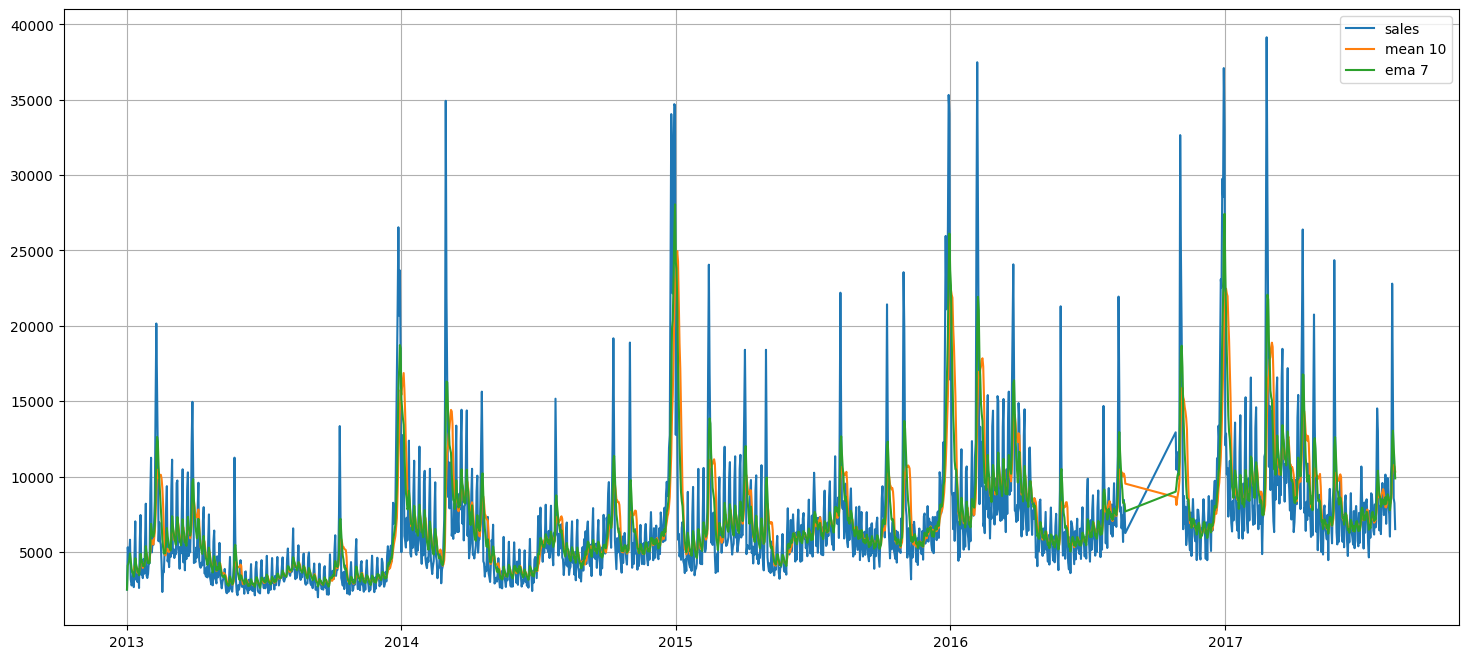

In [ ]:
# строим оконное среднее с окном в 10 точек
df['rolling_mean_10'] = df.sales.rolling(window = 10).mean()

# строим экспоненциально среднее с окном в 7 точек
df['rolling_ema_7'] = df.sales.ewm(span = 7).mean()

# отображаем на графике
f, ax = pyplot.subplots(1, 1, figsize = (18, 8))
ax.plot(df.index, df.sales)            # исходные данные
ax.plot(df.index, df.rolling_mean_10)  # оконное среднее
ax.plot(df.index, df.rolling_ema_7)    # экспоненциально среднее
ax.legend(['sales', 'mean 10', 'ema 7'])
ax.grid()

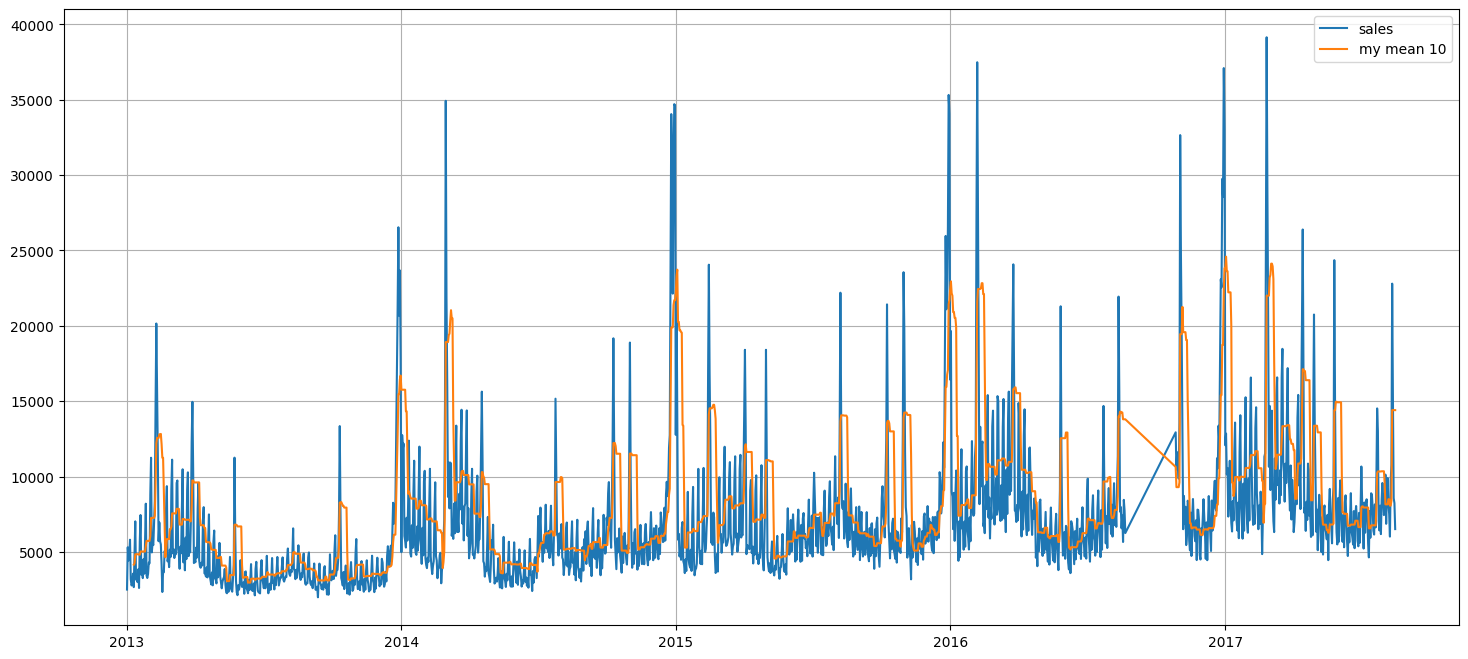

In [ ]:
def my_mean(value):
    '''
    Функция возвращает среднее арифметическое
    между максимальным и минимальным значением.
    '''
    return (max(value) + min(value)) / 2


# среднее арифметическое с окном 10
df['rolling_my_mean_10'] = df.sales.rolling(window = 10).apply(my_mean)

# отображаем на графике
f, ax = pyplot.subplots(1, 1, figsize = (18, 8))
ax.plot(df.index, df.sales)               # исходные данные
ax.plot(df.index, df.rolling_my_mean_10)  # среднее арифметическое
ax.legend(['sales', 'my mean 10'])
ax.grid()

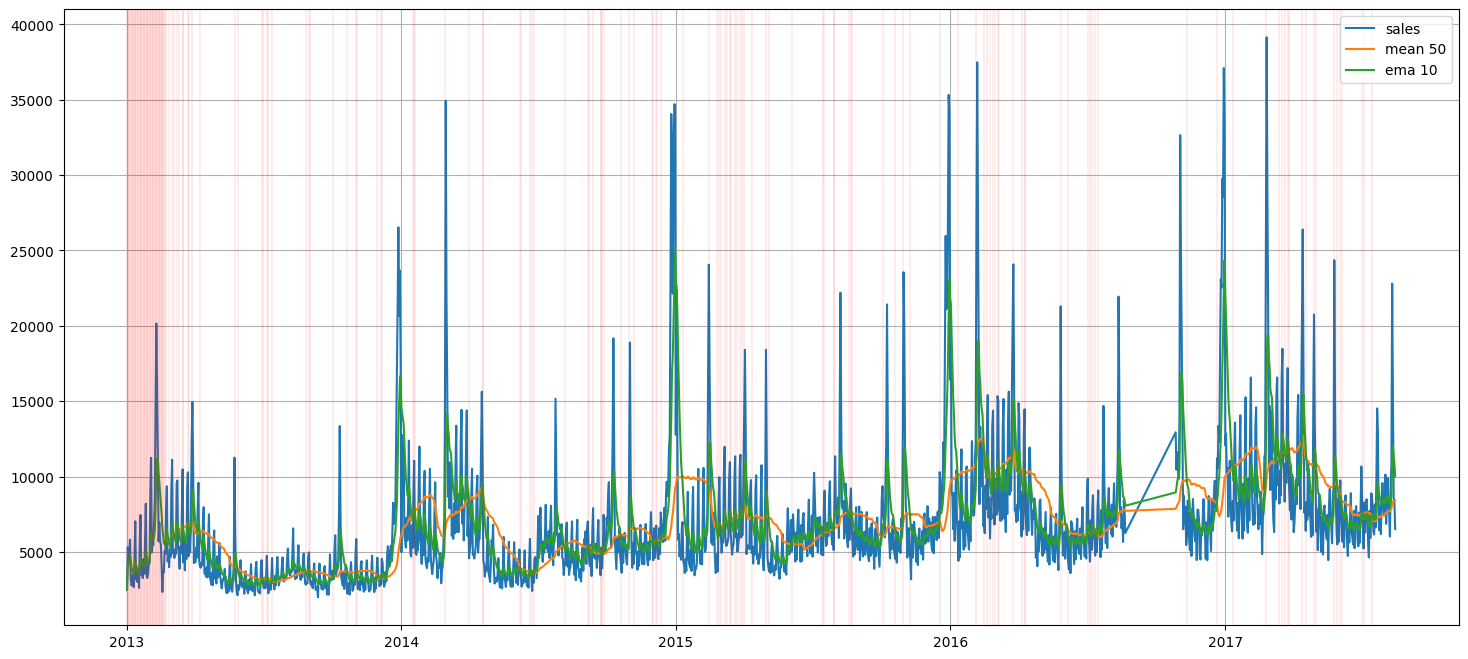

In [ ]:
# строим скользящее среднее с окном 50
df['rolling_mean_50'] = df.sales.rolling(window = 50).mean()

# строим экспоненциальное скользящее среднее с окном 10
df['rolling_ema_10'] = df.sales.ewm(span = 10).mean()

# указываем индексы датафрейма, на которых одно скользящее пересекается с другим
mask = np.sign(df['rolling_mean_50'] - df['rolling_ema_10']).diff() != 0
indexes = df[mask].index

# отображаем на графике
f, ax = pyplot.subplots(1, 1, figsize = (18, 8))
ax.plot(df.index, df.sales)            # исходные данные
ax.plot(df.index, df.rolling_mean_50)  # оконное среднее
ax.plot(df.index, df.rolling_ema_10)   # экспоненциально среднее

for i in range(len(indexes)):
    ax.axvline(indexes[i], lw = 0.1, c = 'r')

ax.legend(['sales', 'mean 50', 'ema 10'])
ax.grid()

### Лаги

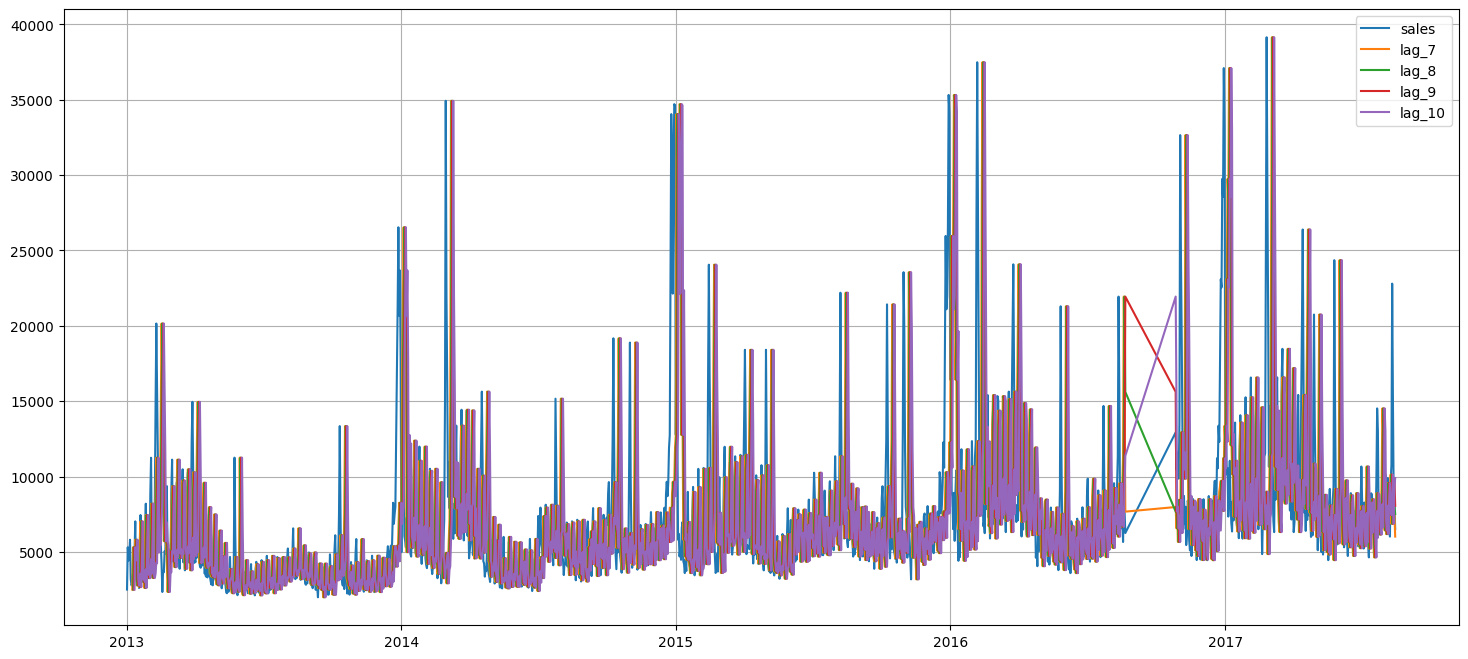

In [ ]:
# получаем лаговые факторы с 7-го по 10-й и отображаем на графике
f, ax = pyplot.subplots(1, 1, figsize = (18, 8))
ax.plot(df.index, df.sales)

for i in range(7, 11):
    df['lag_{}'.format(i)] = df.sales.shift(i)
    ax.plot(df.index, df['lag_' + str(i)])

ax.legend(['sales', 'lag_7', 'lag_8', 'lag_9', 'lag_10'])
ax.grid()

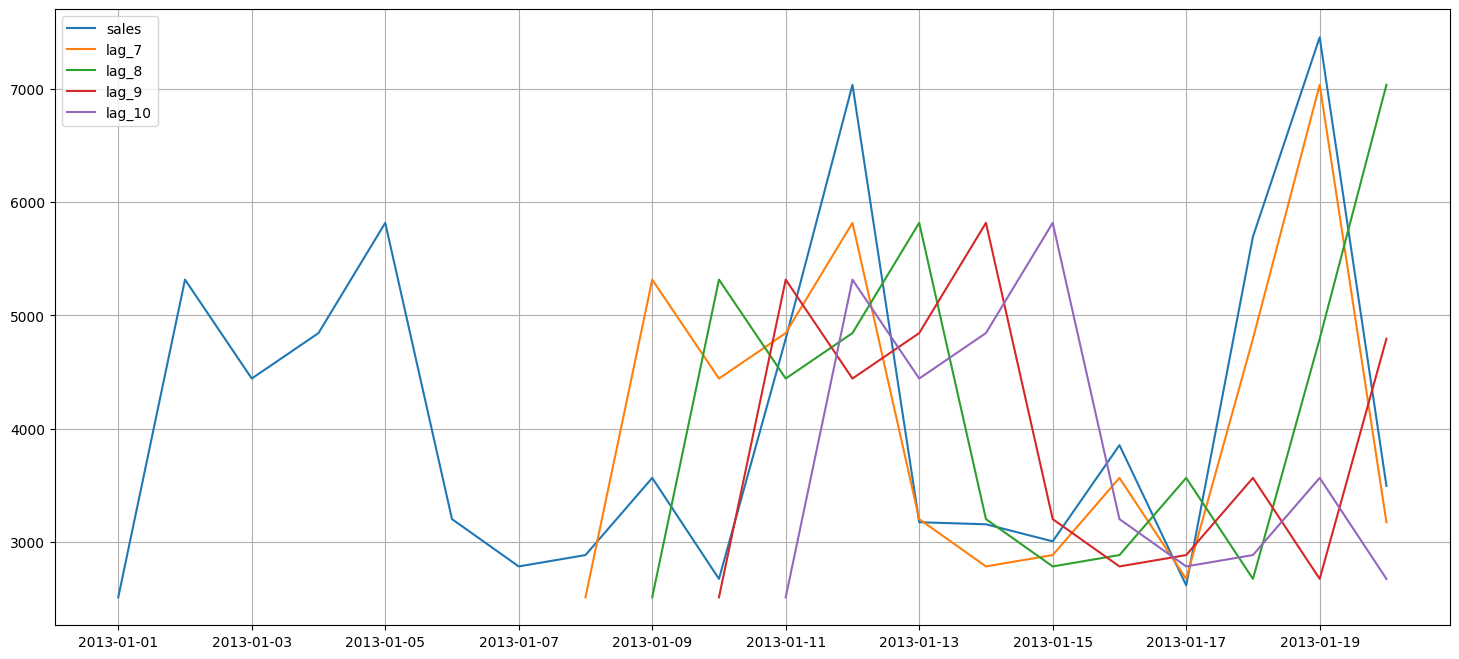

In [ ]:
# отображаем на графике первые 20 значений
f, ax = pyplot.subplots(1, 1, figsize = (18, 8))
ax.plot(df.index[:20], df.sales[:20])

for i in range(7, 11):
    ax.plot(df.index[:20], df['lag_' + str(i)][:20])

ax.legend(['sales', 'lag_7', 'lag_8', 'lag_9', 'lag_10'])
ax.grid()

# ARIMA

Выбераем продукт с номером 103501 и приводим данные к виду временного ряда с группировкой по дате и агрегацией.

In [ ]:
col = ['date', 'item_nbr', 'unit_sales']
train = pd.read_csv(
    '/content/drive/MyDrive/train.csv.zip',
    usecols = col,
    chunksize = 10000000
)
top1 = pd.concat(
    (x.query('item_nbr == 103501') for x in train),
    ignore_index = True
)
top1['date'] = pd.to_datetime(top1['date'])

# подготавливаем данные
unit_sales_by_date = top1.groupby('date')['unit_sales'].sum()

Проводим тест Адфуллера.

In [ ]:
test = adfuller(unit_sales_by_date)
print('ADF statistic:', round(test[0], 3))
print('p-value:      ', round(test[1], 7))
print('\nCritical values:')

for key, value in test[4].items():
    print(f'\t{key}: {round(value, 3)}')

# проверяем, больше ли критического полученное значение для нашего ряда
if test[0] > test[4]['5%']:
    print('\nРяд не стационарен.')
else:
    print('\nРад стационарен.')

ADF statistic: -4.154
p-value:       0.0007863

Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

Рад стационарен.


Строим прогноз методом скользящего среднего с окном 6 и рассчитываем метрики MSE, MAE, MAPE.

MSE:  287.1
MAE:  13.42
MAPE: 0.1721


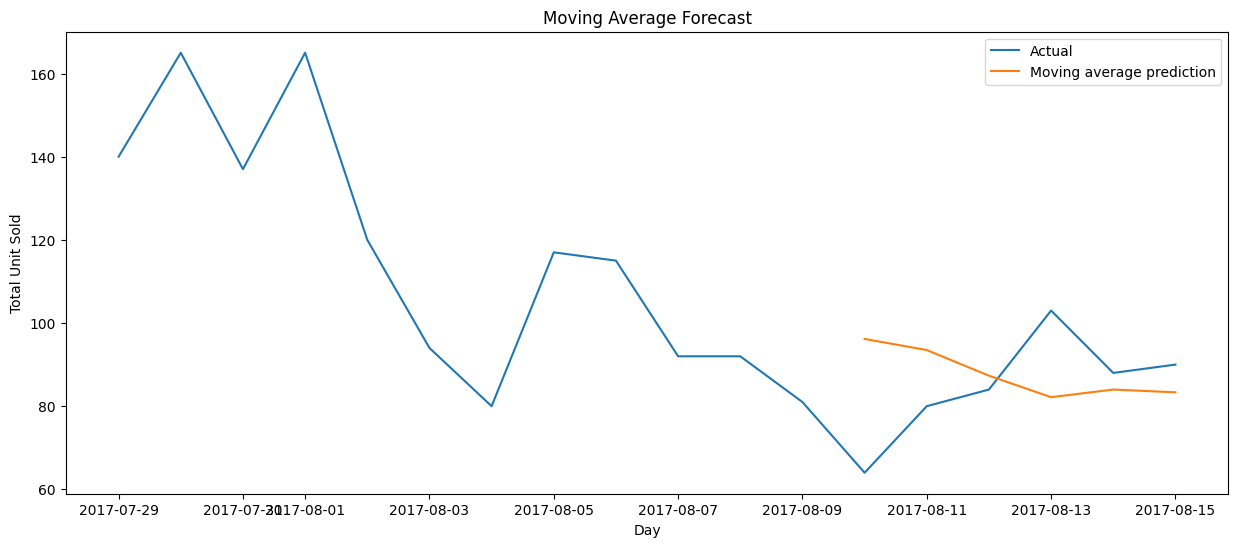

In [ ]:
# объявляем функцию для рассчёта скользящего среднего
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time : time + window_size].mean())
    return np.array(forecast)


# строим прогноз
moving_average_days = 6
shown_train_size = moving_average_days * 3
moving_avg = moving_average_forecast(unit_sales_by_date, moving_average_days)
moving_avg = pd.Series(
    moving_avg,
    index = unit_sales_by_date[moving_average_days:].index
)

# рассчитываем метрики
print('MSE: ', round(mean_squared_error(
    unit_sales_by_date[-moving_average_days:],
    moving_avg[-moving_average_days:]
), 1))
print('MAE: ', round(mean_absolute_error(
    unit_sales_by_date[-moving_average_days:],
    moving_avg[-moving_average_days:]
), 2))
print('MAPE:', round(mean_absolute_percentage_error(
    unit_sales_by_date[-moving_average_days:],
    moving_avg[-moving_average_days:]
), 4))

# визуализируем
pyplot.figure(figsize = (15, 6))
pyplot.plot(unit_sales_by_date[-shown_train_size:], label = 'Actual')
pyplot.plot(
    moving_avg[-moving_average_days:],
    label = 'Moving average prediction'
)
pyplot.ylabel('Total Unit Sold')
pyplot.xlabel('Day')
pyplot.title('Moving Average Forecast')
pyplot.legend(loc = 'upper right');

Делаем лаги с 1 по 6.

In [ ]:
df = pd.DataFrame()
df['original_values'] = unit_sales_by_date

for i in range(1, 7):
    df[f'shift_{i}'] = df['original_values'].shift(i)

df.dropna(inplace = True)
df.head()

,original_values,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6
date,,,,,,,
2013-01-08,103.0,98.0,173.0,160.0,155.0,153.0,185.0
2013-01-09,71.0,103.0,98.0,173.0,160.0,155.0,153.0
2013-01-10,83.0,71.0,103.0,98.0,173.0,160.0,155.0
2013-01-11,91.0,83.0,71.0,103.0,98.0,173.0,160.0
2013-01-12,118.0,91.0,83.0,71.0,103.0,98.0,173.0


Откладываем последний день в тестовую выборку для совершения предсказания.

In [ ]:
# разделяем данные на тренировочную и тестовую выборки
predict_size = 1
x_train = df[:-predict_size].drop(['original_values'], axis = 1)
y_train = df[:-predict_size]['original_values']
x_test = df[-predict_size:].drop(['original_values'], axis = 1)
y_test = df[-predict_size:]['original_values']

Делаем прогноз линейной регрессией и считаем значения метрик MSE, MAE, MAPE.

In [ ]:
# обучем модель линейной регрессии
reg = LinearRegression().fit(x_train, y_train)

# делаем прогноз
ar_prediction = reg.predict(x_test)
print('Original:  ', y_test.values[0])
print('Prediction:', round(ar_prediction[0], 2), '\n')

# считаем метрики
print('MSE: ', round(mean_squared_error(y_test, ar_prediction), 3))
print('MAE: ', round(mean_absolute_error(y_test, ar_prediction), 3))
print('MAPE:', round(mean_absolute_percentage_error(y_test, ar_prediction), 5))

Original:   90.0
Prediction: 88.84 

MSE:  1.354
MAE:  1.164
MAPE: 0.01293


Откладываем 2 последних дня в тестовую выборку для совершения предсказания, делаем прогноз линейной регрессией и считаем значения метрик MSE, MAE, MAPE.

MSE:  58.92
MAE:  7.644
MAPE: 0.08582


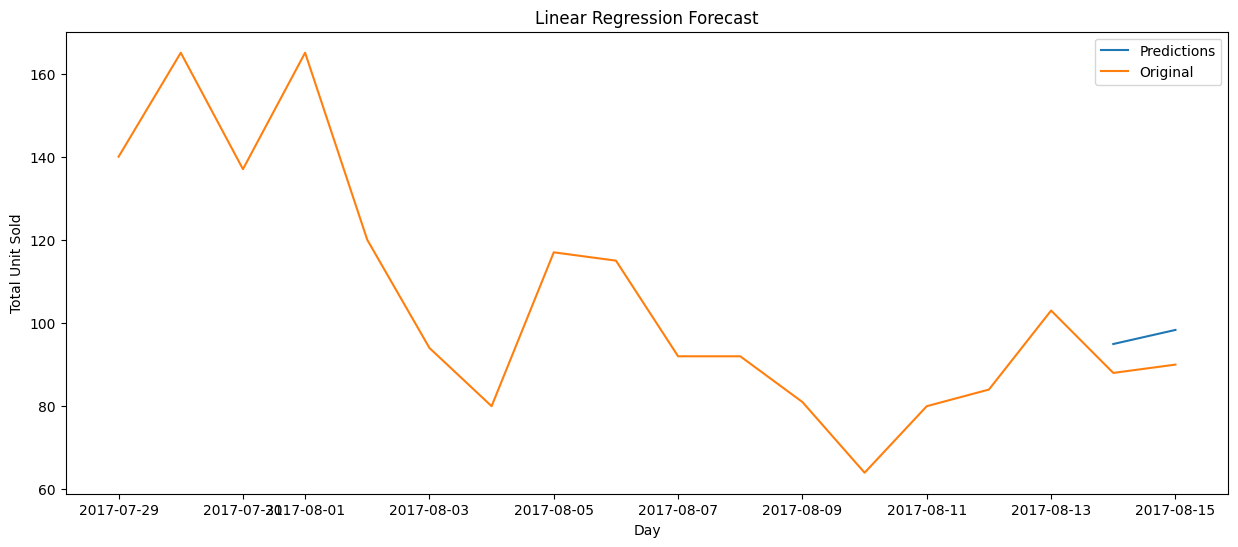

In [ ]:
# разделяем данные на тренировочную и тестовую выборки
predict_size = 2
x_train = df[:-predict_size].drop(['original_values', 'shift_1'], axis = 1)
y_train = df[:-predict_size]['original_values']
x_test = df[-predict_size:].drop(['original_values', 'shift_1'], axis = 1)
y_test = df[-predict_size:]['original_values']

# обучем модель линейной регрессии
reg = LinearRegression().fit(x_train, y_train)

# делаем прогноз
ar_predictions = pd.Series(reg.predict(x_test), index = x_test.index)

# считаем метрики
print('MSE: ', round(mean_squared_error(y_test, ar_predictions), 2))
print('MAE: ', round(mean_absolute_error(y_test, ar_predictions), 3))
print('MAPE:', round(mean_absolute_percentage_error(y_test, ar_predictions), 5))

# визуализируем
pyplot.figure(figsize = (15, 6))
pyplot.plot(ar_predictions, label = 'Predictions')
pyplot.plot(
    pd.concat([y_train, y_test], axis = 0)[-shown_train_size:],
    label = 'Original'
)
pyplot.xlabel('Day')
pyplot.ylabel('Total Unit Sold')
pyplot.title('Linear Regression Forecast')
pyplot.legend(loc = 'upper right');

Определяем p и q для модели ARIMA. d мы уже знаем - это 0.

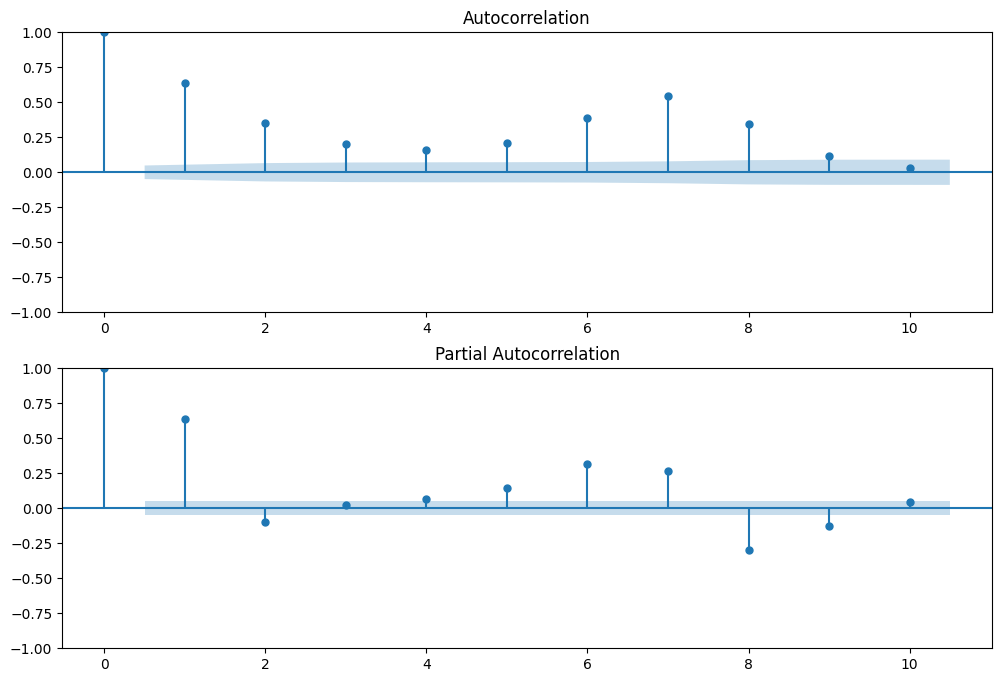

In [ ]:
fig = pyplot.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = api.graphics.tsa.plot_acf(unit_sales_by_date, lags = 10, ax = ax1)
ax2 = fig.add_subplot(212)
fig = api.graphics.tsa.plot_pacf(unit_sales_by_date, lags = 10, ax = ax2)

После изучения коррелограммы ACF можно сделать вывод, что q = 8, т. к. на ней все лаги сильно отличаются от нуля. По коррелограмме PACF можно предположить, что p = 8, т. к. на лагах 6, 7 и 8 значения функции резко возрастает.

Строим ARIMA и сравниваем метрики.

MSE:  1.605
MAE:  1.112
MAPE: 0.01242


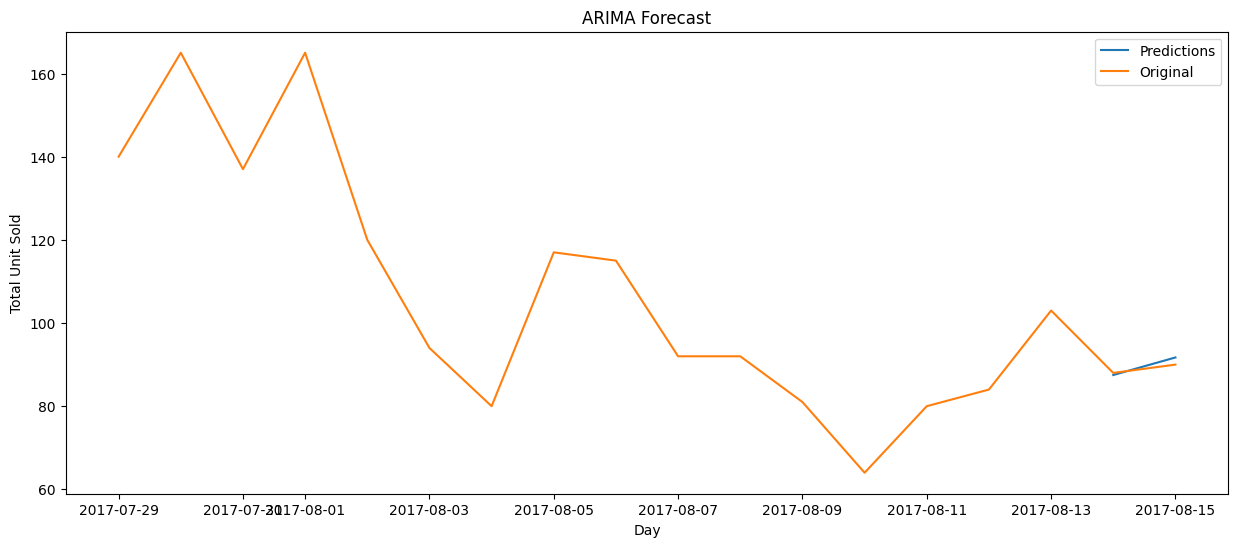

In [ ]:
# обучаем ARIMA модель
model = ARIMA(y_train.values, order = (8, 0, 8))
train_size = len(y_train)
test_size = predict_size
arima_predictions = model.fit(method_kwargs = {'maxiter': 600}).predict(
    start = train_size,
    end = train_size + test_size - 1,
    dynamic = False
)

# считаем метрики
print('MSE: ', round(mean_squared_error(y_test, arima_predictions), 3))
print('MAE: ', round(mean_absolute_error(y_test, arima_predictions), 3))
print(
    'MAPE:',
    round(mean_absolute_percentage_error(y_test, arima_predictions), 5)
)

# визуализируем
pyplot.figure(figsize = (15, 6))
pyplot.plot(
    pd.Series(arima_predictions, index = y_test.index),
    label = 'Predictions'
)
pyplot.plot(
    pd.concat([y_train, y_test], axis = 0)[-shown_train_size:],
    label = 'Original'
)
pyplot.xlabel('Day')
pyplot.ylabel('Total Unit Sold')
pyplot.title('ARIMA Forecast')
pyplot.legend(loc = 'upper right');

Вывод: для небольших прогнозов (на 2 дня) модель ARIMA показывает лучшие показатели по метрикам MSE, MAE и MAPE, в сравнении с линейной регрессией.

# FBProphet

Приводим данные train.csv к виду временного ряда, сгруппированного по дате, с агрегирующей функцие sum() для столбца unit_sales. Получаем временной ряд с двумя столбцами: дата и sum_unit_sales. Отображаем на графике.

In [ ]:
# загружаем данные
col = ['date', 'unit_sales']
gen = pd.read_csv(
    '/content/drive/MyDrive/train.csv.zip',
    usecols = col,
    chunksize = 10000000
)
df = pd.concat((x for x in gen), ignore_index = True)
df.head()

,date,unit_sales
0,2013-01-01,7.0
1,2013-01-01,1.0
2,2013-01-01,2.0
3,2013-01-01,1.0
4,2013-01-01,1.0


In [ ]:
# приводим данные к виду временного ряда
sales = df.groupby('date')['unit_sales'].sum()
sales.head()

date
2013-01-01      2511.619
2013-01-02    496092.418
2013-01-03    361429.231
2013-01-04    354459.677
2013-01-05    477350.121
Name: unit_sales, dtype: float64

In [ ]:
# отображаем на графике
py.iplot([go.Scatter(x = sales.index, y = sales)])

Хорошо видно влияние сезонности и праздников на общее количество покупок.

Попробуем выполнить предсказание пророком (prophet) на год вперёд (periods = 365). Отобразим на графике. Посчитаем RMSE.

In [ ]:
# подготавливаем данные
sales = pd.DataFrame(sales).reset_index()
sales.columns = ['ds', 'y']
sales.head()

,ds,y
0,2013-01-01,2511.619
1,2013-01-02,496092.418
2,2013-01-03,361429.231
3,2013-01-04,354459.677
4,2013-01-05,477350.121


In [ ]:
# выполняем предсказание
m = Prophet()
m.fit(sales)
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppnng1485/snmypf_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppnng1485/960xzt4p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21163', 'data', 'file=/tmp/tmppnng1485/snmypf_m.json', 'init=/tmp/tmppnng1485/960xzt4p.json', 'output', 'file=/tmp/tmppnng1485/prophet_model8dvtx71i/prophet_model-20240806102905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:29:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:29:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# так выглядят предсказания
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,333493.895442,232846.057592,524185.814140,333493.895442,333493.895442,43501.200772,43501.200772,43501.200772,-68155.086369,-68155.086369,-68155.086369,111656.287140,111656.287140,111656.287140,0.0,0.0,0.0,376995.096214
1,2013-01-02,333867.913300,252650.624580,522100.331657,333867.913300,333867.913300,55549.474127,55549.474127,55549.474127,-44198.862166,-44198.862166,-44198.862166,99748.336293,99748.336293,99748.336293,0.0,0.0,0.0,389417.387428
2,2013-01-03,334241.931159,161808.508938,425762.837485,334241.931159,334241.931159,-44054.182852,-44054.182852,-44054.182852,-131874.531664,-131874.531664,-131874.531664,87820.348812,87820.348812,87820.348812,0.0,0.0,0.0,290187.748306
3,2013-01-04,334615.949017,225015.133628,490254.773488,334615.949017,334615.949017,19013.060077,19013.060077,19013.060077,-57037.349088,-57037.349088,-57037.349088,76050.409165,76050.409165,76050.409165,0.0,0.0,0.0,353629.009094
4,2013-01-05,334989.966875,391304.945815,678463.205480,334989.966875,334989.966875,198610.676245,198610.676245,198610.676245,134004.159043,134004.159043,134004.159043,64606.517202,64606.517202,64606.517202,0.0,0.0,0.0,533600.643120


In [ ]:
# отображаем на графике
py.iplot([
    go.Scatter(x = sales['ds'], y = sales['y'], name = 'y'),
    go.Scatter(x = forecast['ds'], y = forecast['yhat'], name = 'yhat'),
    go.Scatter(
        x = forecast['ds'],
        y = forecast['yhat_upper'],
        fill = 'tonexty',
        mode = 'none',
        name = 'upper'
    ),
    go.Scatter(
        x = forecast['ds'],
        y = forecast['yhat_lower'],
        fill = 'tonexty',
        mode = 'none',
        name = 'lower'
    ),
    go.Scatter(x = forecast['ds'], y = forecast['trend'], name = 'Trend')
])

# считаем RMSE
print(
    'RMSE:',
    round(np.sqrt(mean_squared_error(forecast['yhat'][:-365], sales['y'])))
)

RMSE: 108067


Поэкспериментируем с коэффициентом changepoint_prior_scale. По умолчанию этот параметр установлен на 0.05, переберём значения меньше/больше 0.5 в диапозоне от 0.05 до 0.95 с шагом 0.01.

Увеличение коэффициента changepoint_prior_scale делает тренд более гибким.

Для объективного рассчёта RMSE отложим в тестовую выборку последние 365 дней.

In [ ]:
# разбиваем временной ряд на тренировочную и тестовую части
train, test = sales[:-365], sales[-365:]

# перебираем значения коэффициента и смотрим как меняется RMSE
coef = list(np.arange(0.05, 0.96, 0.01))
rmse = []

for value in coef:
    m = Prophet(changepoint_prior_scale = value)
    m.fit(train)
    future = m.make_future_dataframe(periods = 365)
    forecast = m.predict(future)
    rmse.append(np.sqrt(mean_squared_error(forecast['yhat'][-365:], test['y'])))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8_rqvuep/8ne76bz5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8_rqvuep/way20c4p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77708', 'data', 'file=/tmp/tmp8_rqvuep/8ne76bz5.json', 'init=/tmp/tmp8_rqvuep/way20c4p.json', 'output', 'file=/tmp/tmp8_rqvuep/prophet_modelzxha7wv0/prophet_model-20240806075327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:53:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:53:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8_

In [ ]:
# отображаем результат на графике
py.iplot([go.Scatter(x = coef, y = rmse)])

Наименьшее значение RMSE на тестовой выборке достигается при коэффициенте changepoint_prior_scale = 0.08, после этого тренд переобучается.

Отобразим результаты с подобранным коэффициентом на графике.

In [ ]:
# обучаем модель на всех данных
m = Prophet(changepoint_prior_scale = 0.08)
m.fit(sales)
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppnng1485/4jl2w40t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppnng1485/px9tf6df.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14568', 'data', 'file=/tmp/tmppnng1485/4jl2w40t.json', 'init=/tmp/tmppnng1485/px9tf6df.json', 'output', 'file=/tmp/tmppnng1485/prophet_model9c7vbwav/prophet_model-20240806102924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:29:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:29:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# отображаем на графике
py.iplot([
    go.Scatter(x = sales['ds'], y = sales['y'], name = 'y'),
    go.Scatter(x = forecast['ds'], y = forecast['yhat'], name = 'yhat'),
    go.Scatter(
        x = forecast['ds'],
        y = forecast['yhat_upper'],
        fill = 'tonexty',
        mode = 'none',
        name = 'upper'
    ),
    go.Scatter(
        x = forecast['ds'],
        y = forecast['yhat_lower'],
        fill = 'tonexty',
        mode = 'none',
        name = 'lower'
    ),
    go.Scatter(x = forecast['ds'], y = forecast['trend'], name = 'Trend')
])

# смотрим как изменилась ошибка
print(
    'RMSE:',
    round(np.sqrt(mean_squared_error(forecast['yhat'][:-365], sales['y'])))
)

RMSE: 105039


На тренировочной выборке значение RMSE также уменьшилось. Тенденция начала учитывать под-тренды середины года, особенно это заметно на промежутке с 2014 по 2016 гг.

Добавим в модель месячную сезонность, отобразим на графике, посчитаем ошибку.

In [ ]:
m = Prophet(changepoint_prior_scale = 0.08)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.fit(sales)
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppnng1485/dxczlmv2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppnng1485/q2zsdtvm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31688', 'data', 'file=/tmp/tmppnng1485/dxczlmv2.json', 'init=/tmp/tmppnng1485/q2zsdtvm.json', 'output', 'file=/tmp/tmppnng1485/prophet_modelqm5c5ysp/prophet_model-20240806102944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:29:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:29:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# отображаем на графике
py.iplot([
    go.Scatter(x = sales['ds'], y = sales['y'], name = 'y'),
    go.Scatter(x = forecast['ds'], y = forecast['yhat'], name = 'yhat'),
    go.Scatter(
        x = forecast['ds'],
        y = forecast['yhat_upper'],
        fill = 'tonexty',
        mode = 'none',
        name = 'upper'
    ),
    go.Scatter(
        x = forecast['ds'],
        y = forecast['yhat_lower'],
        fill = 'tonexty',
        mode = 'none',
        name = 'lower'
    ),
    go.Scatter(x = forecast['ds'], y = forecast['trend'], name = 'Trend')
])

# считаем ошибку
print(
    'RMSE:',
    round(np.sqrt(mean_squared_error(forecast['yhat'][:-365], sales['y'])))
)

RMSE: 98826


Добавление в модель месячной сезонности снизило ошибку и улучшило модель.

Улучшим модель добавлением данных о праздниках, отобразим результат.

In [ ]:
# загружаем данные
df_holidays_events = pd.read_csv('holidays_events.csv')
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
# пророку нужны два столбца (праздник и ds)
holidays = df_holidays_events[['description', 'date']]
holidays.columns = ['holiday', 'ds']
holidays.tail()

,holiday,ds
345,Navidad-3,2017-12-22
346,Navidad-2,2017-12-23
347,Navidad-1,2017-12-24
348,Navidad,2017-12-25
349,Navidad+1,2017-12-26


In [ ]:
m = Prophet(changepoint_prior_scale = 0.08, holidays = holidays)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
m.fit(sales)
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppnng1485/3qowp0vx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppnng1485/o952i1wj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15570', 'data', 'file=/tmp/tmppnng1485/3qowp0vx.json', 'init=/tmp/tmppnng1485/o952i1wj.json', 'output', 'file=/tmp/tmppnng1485/prophet_model2b7r34et/prophet_model-20240806122119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:21:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# отображаем на графике
py.iplot([
    go.Scatter(x = sales['ds'], y = sales['y'], name = 'y'),
    go.Scatter(x = forecast['ds'], y = forecast['yhat'], name = 'yhat'),
    go.Scatter(
        x = forecast['ds'],
        y = forecast['yhat_upper'],
        fill = 'tonexty',
        mode = 'none',
        name = 'upper'
    ),
    go.Scatter(
        x = forecast['ds'],
        y = forecast['yhat_lower'],
        fill = 'tonexty',
        mode = 'none',
        name = 'lower'
    ),
    go.Scatter(x = forecast['ds'], y = forecast['trend'], name = 'Trend')
])

# считаем ошибку
print(
    'RMSE:',
    round(np.sqrt(mean_squared_error(forecast['yhat'][:-365], sales['y'])))
)

RMSE: 76081


Нам удалось улучшить метрику, а также прогнозируемый период после 15 августа 2017 года выглядит неплохо. Однако мы не смогли спрогнозировать падение на 1 января 2018 года. Возможно это связано с тем, что у нас нет праздничных дат на новый период прогнозирования. Также с этим могут быть связаны отрицательные спрогнозированные значения на 1 января 2013, 2014 и 2015 гг., а также затухание падений на 1 января 2016 и 2017 гг. Модель хорошо предсказывает продажи на 23 декабря.

# Бустинги/деревья

Загрузим датасет, сгруппируем по датам и разобъём данные на train и test.

In [83]:
# загружаем данные
col = ['date', 'unit_sales']
gen = pd.read_csv(
    '/content/drive/MyDrive/train.csv.zip',
    usecols = col,
    chunksize = 10000000,
)
df = pd.concat((x for x in gen), ignore_index = True)

# приводим данные к виду временного ряда
sales = df.groupby('date').sum().rename(columns = {'unit_sales': 'sales'})

# откладываем последний год в тестовую выборку
sales_train = sales[:-365]
sales_test = sales[-365:]

Содаём временные признаки.

In [84]:
def create_features(df, label = None):
    """
    Создаём признаки из datetime индекса.
    """
    df['date'] = pd.to_datetime(df.index)
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    X = df[[
        'dayofweek',
        'quarter',
        'month',
        'year',
        'dayofyear',
        'dayofmonth',
        'weekofyear'
    ]]
    if label:
        y = df[label]
        return X, y
    return X


X_train, y_train = create_features(sales_train.copy(), label = 'sales')
X_test, y_test = create_features(sales_test.copy(), label = 'sales')

Инициализируем модели XGBoost и CatBoost.

In [85]:
xgb_reg = XGBRegressor(n_estimators = 1000, early_stopping_ronds = 50)
cb_reg = CatBoostRegressor(n_estimators = 1000)

Обучаем модели.

In [86]:
xgb_reg.fit(
    X_train,
    y_train,
    eval_set = [(X_train, y_train), (X_test, y_test)],
    verbose = False
)
cb_reg.fit(
    X_train,
    y_train,
    eval_set = [(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds = 50,
    verbose = False
)

Отобразим важность признаков.

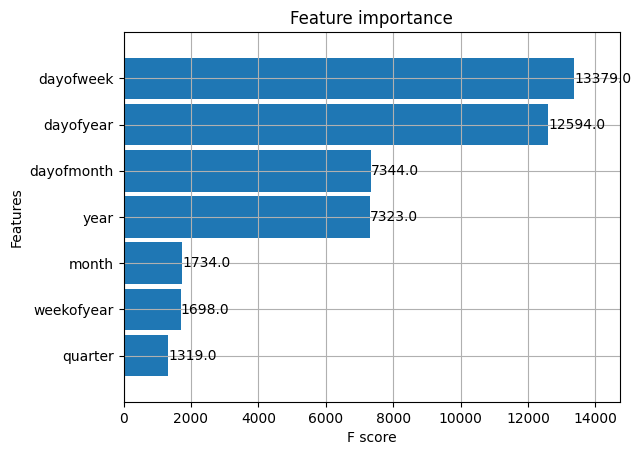

In [87]:
plot_importance(xgb_reg, height = 0.9);

Мы видим, что день недели чаще всего использовался для разделения деревьев, а затем следуют день года и день месяца. Признаки включающие в себя больше одного дня имеют меньшее значение, наименьшее из которых имеет квартал.

Сделаем прогноз  и отобразим результ на графике.

In [88]:
# делаем прогноз
sales_test['xgb_pred'] = xgb_reg.predict(X_test)
sales_test['cb_pred'] = cb_reg.predict(X_test)

# отображаем на графике
py.iplot([
    go.Scatter(x = sales_test.index, y = sales_test['sales'], name = 'sales'),
    go.Scatter(
        x = sales_test.index,
        y = sales_test['xgb_pred'],
        name = 'xgb_pred'
    ),
    go.Scatter(
        x = sales_test.index,
        y = sales_test['cb_pred'],
        name = 'cb_pred'
    )
])

- Предсказания выглядят довольно неплохо - модели угадывают в какой день значение вырастет, а когда упадёт.
- Обе модели в среднем показывают меньший результат предсказания в сравнении с истинными значениями - можно преположить, что данные имеют недостаточно признаков для качественного предсказания тренда.
- Следует отметить, что модель XGBoost имеет больший разброс предсказаний по сравнинию с моделью CatBoost.
- Обе модели не справились с предсказанием минимального значения 1 января.

В подтверждение выводов взглянем на описательные статистики:

In [89]:
round(sales_test.describe())

,sales,xgb_pred,cb_pred
count,365.0,365.0,365.0
mean,841168.0,764360.0,746985.0
std,184138.0,151877.0,123354.0
min,12083.0,508153.0,528213.0
25%,721276.0,658923.0,659318.0
50%,791762.0,717457.0,707185.0
75%,961777.0,864643.0,830628.0
max,1463084.0,1264185.0,1125362.0


Оценим метрики MAE, MAPE, MSE по результатам двух моделей.

In [90]:
# считаем метрики для XGBoost
xgb_mae = mean_absolute_error(sales_test['sales'], sales_test['xgb_pred'])
xgb_mse = mean_squared_error(sales_test['sales'], sales_test['xgb_pred'])
xgb_mape = mean_absolute_percentage_error(
    sales_test['sales'], sales_test['xgb_pred']
)

# считаем метрики для CatBoost
cb_mae = mean_absolute_error(sales_test['sales'], sales_test['cb_pred'])
cb_mse = mean_squared_error(sales_test['sales'], sales_test['cb_pred'])
cb_mape = mean_absolute_percentage_error(
    sales_test['sales'], sales_test['cb_pred']
)

# объединяем результаты в датафрейм
error_df = pd.DataFrame({
    'XGBoost': [round(xgb_mae), round(xgb_mape * 100), round(xgb_mse)],
    'CatBoost': [round(cb_mae), round(cb_mape * 100), round(cb_mse)]
},index = ['MAE', 'MAPE %', 'MSE'])
error_df

,XGBoost,CatBoost
MAE,101976,107460
MAPE %,34,31
MSE,19127689850,21498168905


Модель XGBoost показала чуть лучший результат по метрикам MAE и MSE, однако она уступает модели CatBoost по метрике MAPE - предполагаю, что это связано с разницей в разбросе предсказаний.

Добавим данные о праздничных днях. Используем библиотеку holidays.

In [91]:
# загружаем праздничные дни Эквадора
ec_holidays = holidays.EC()

# добавляем данные в тренировочную выборку
X_train['date'] = pd.to_datetime(X_train.index)
X_train['holiday'] = X_train['date'].apply(
    lambda x: 1 if x in ec_holidays else 0
)
X_train.drop('date', axis = 1, inplace = True)

# добавляем данные в тестовую выборку
X_test['date'] = pd.to_datetime(X_test.index)
X_test['holiday'] = X_test['date'].apply(
    lambda x: 1 if x in ec_holidays else 0
)
X_test.drop('date', axis = 1, inplace = True)

Обучаем модели, фиксируем значения метрик.

In [92]:
# инициализируем модели XGBoost и CatBoost
xgb_reg = XGBRegressor(n_estimators = 1000, early_stopping_ronds = 50)
cb_reg = CatBoostRegressor(n_estimators = 1000)

# обучаем модели
xgb_reg.fit(
    X_train,
    y_train,
    eval_set = [(X_train, y_train), (X_test, y_test)],
    verbose = False
)
cb_reg.fit(
    X_train,
    y_train,
    eval_set = [(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds = 50,
    verbose = False
)

# делаем прогноз
sales_test['xgb_pred'] = xgb_reg.predict(X_test)
sales_test['cb_pred'] = cb_reg.predict(X_test)

# считаем метрики для XGBoost
xgb_mae = mean_absolute_error(sales_test['sales'], sales_test['xgb_pred'])
xgb_mse = mean_squared_error(sales_test['sales'], sales_test['xgb_pred'])
xgb_mape = mean_absolute_percentage_error(
    sales_test['sales'], sales_test['xgb_pred']
)

# считаем метрики для CatBoost
cb_mae = mean_absolute_error(sales_test['sales'], sales_test['cb_pred'])
cb_mse = mean_squared_error(sales_test['sales'], sales_test['cb_pred'])
cb_mape = mean_absolute_percentage_error(
    sales_test['sales'], sales_test['cb_pred']
)

# объединяем результаты в датафрейм
error_df = error_df.join(pd.DataFrame({
    'XGB + holidays': [round(xgb_mae), round(xgb_mape * 100), round(xgb_mse)],
    'CB + holidays': [round(cb_mae), round(cb_mape * 100), round(cb_mse)]
},index = ['MAE', 'MAPE %', 'MSE']))
error_df

,XGBoost,CatBoost,XGB + holidays,CB + holidays
MAE,101976,107460,100257,108017
MAPE %,34,31,34,28
MSE,19127689850,21498168905,19349078826,22305340023


Добавляем лаги.

In [93]:
# соберём тренировочную и тестовую выборки воедино
sales_modified = pd.concat([X_train.join(y_train), X_test.join(y_test)])

# добавляем 7 лагов
for lag in range(len(y_test), len(y_test) + 7):
    sales_modified[f'shift_{lag}'] = sales_modified['sales'].shift(lag)

sales_modified.dropna(inplace = True)
sales_modified.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,holiday,sales,shift_365,shift_366,shift_367,shift_368,shift_369,shift_370,shift_371
date,,,,,,,,,,,,,,,,
2014-01-08,2,1,1,2014,8,8,2,0,636176.8522,336122.801,519695.401,477350.121,354459.677,361429.231,496092.418,2511.619
2014-01-09,3,1,1,2014,9,9,2,0,496377.9335,318347.778,336122.801,519695.401,477350.121,354459.677,361429.231,496092.418
2014-01-10,4,1,1,2014,10,10,2,0,543055.3286,302530.809,318347.778,336122.801,519695.401,477350.121,354459.677,361429.231
2014-01-11,5,1,1,2014,11,11,2,0,787321.4560,258982.003,302530.809,318347.778,336122.801,519695.401,477350.121,354459.677
2014-01-12,6,1,1,2014,12,12,2,0,844633.5990,289737.685,258982.003,302530.809,318347.778,336122.801,519695.401,477350.121


Пересчитываем модель.

In [94]:
# переопределяем тренировочную и тестовую выборки
sales_train = sales_modified[:-365]
sales_test = sales_modified[-365:]
X_train = sales_train.drop('sales', axis = 1)
X_test = sales_test.drop('sales', axis = 1)
y_train = sales_train['sales']
y_test = sales_test['sales']

# инициализируем модели XGBoost и CatBoost
xgb_reg = XGBRegressor(n_estimators = 1000, early_stopping_ronds = 50)
cb_reg = CatBoostRegressor(n_estimators = 1000)

# обучаем модели
xgb_reg.fit(
    X_train,
    y_train,
    eval_set = [(X_train, y_train), (X_test, y_test)],
    verbose = False
)
cb_reg.fit(
    X_train,
    y_train,
    eval_set = [(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds = 50,
    verbose = False
)

# делаем прогноз
sales_test['xgb_pred'] = xgb_reg.predict(X_test)
sales_test['cb_pred'] = cb_reg.predict(X_test)

# считаем метрики для XGBoost
xgb_mae = mean_absolute_error(sales_test['sales'], sales_test['xgb_pred'])
xgb_mse = mean_squared_error(sales_test['sales'], sales_test['xgb_pred'])
xgb_mape = mean_absolute_percentage_error(
    sales_test['sales'], sales_test['xgb_pred']
)

# считаем метрики для CatBoost
cb_mae = mean_absolute_error(sales_test['sales'], sales_test['cb_pred'])
cb_mse = mean_squared_error(sales_test['sales'], sales_test['cb_pred'])
cb_mape = mean_absolute_percentage_error(
    sales_test['sales'], sales_test['cb_pred']
)

# объединяем результаты в датафрейм
error_df = error_df.join(pd.DataFrame({
    'XGB + lags': [round(xgb_mae), round(xgb_mape * 100), round(xgb_mse)],
    'CB + lags': [round(cb_mae), round(cb_mape * 100), round(cb_mse)]
},index = ['MAE', 'MAPE %', 'MSE']))
error_df

,XGBoost,CatBoost,XGB + holidays,CB + holidays,XGB + lags,CB + lags
MAE,101976,107460,100257,108017,123632,106561
MAPE %,34,31,34,28,35,29
MSE,19127689850,21498168905,19349078826,22305340023,27254628733,20026965355


- Ни добавление праздников, ни лагов не дало однозначного улучшения метрик.
- Лучшая модель по метрикам MAE и MSE - XGBoost построенная на временных признаках от datetime.
- По метрике MAPE, которая даёт легко интерпретируемый процент, показывающий, насколько ошибочны прогнозы, побеждает модель CatBoost обученная на временных признаках + индикатор праздничных дней.